In [1]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import shutil
#from evaluation_functions import *
from plotting import *
from Bio import SeqIO
import matplotlib.patches as patches
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from characterization_from_blast_alignments import *

In [3]:
## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

In [ ]:
import matplotlib
custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 6
hi = 6.69291
wi = 7.08661
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

In [4]:
### define the necessary variables

base_dir = os.getcwd() 

catch_left = ''
catch_right = ''

Barcodes = {"BC1_fwd": "CCC", 
            "BC1_rev" : "CCC", 
            "BC2_fwd":	"AAA",
            "BC2_rev":	"AAA", 
            "BC3_fwd":	"TTT",
            "BC3_rev":	"TTT",}

Primer_seq = {"_fwd": "cgccgCATGGAAGCGAT".upper(),
              "_rev":"cgcacgCGGTTATCCATCG".upper()}

Primer_out_of_triplets = {"_fwd": 0, 
                          "_rev": 2}
amplicon_seq = "cgccgcatggaagcgattaacgaaagcagcggtttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaagggagcctgcatccgccgatggataaccgcgtgcg".upper()

amplicon_AA = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}


ecoli_pref = { ### codons used for retron library (RL8) construction
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

In [6]:
variant = "R36"
BCs_per_var = {"R35": ["BC1", "BC2"],
               "R36": ["BC1", "BC2", "BC3"],
               }

In [186]:

### make sure to run the second code chunk before this one, since the primer dict could have been updated during analysis of the repeated seq run of S2, S3
remove_read_qualities = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-',] 
#remove_read_qualities =['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/']
ref_gene = amplicon_seq

used_BCs = BCs_per_var[variant]

filter_for_n_mut = False# True
read_len_treshold = None#(40,40)

## variant 4
a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = variant, arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True, quality_score=remove_read_qualities, base_dir = f"{os.getcwd()}/data/fastq/{variant}"
)

all_reads, all_ids = demultiplex_reads(a_seq, b_seq, ref_gene = ref_gene ,Barcodes=Barcodes, Primer_seq=Primer_seq, used_Barcodes = used_BCs, Sections = [""], max_mismatch_primerseq = 5, filter_for_n_mut = filter_for_n_mut, n_mut_treshold = 10, a_ids=a_ids, b_ids=b_ids,  read_len_treshold= read_len_treshold, Primer_out_of_triplets= Primer_out_of_triplets, cut_primer_start=True, cut_BC_seq=True)


#### settings
amplicon_DNA = amplicon_seq[:-2]
amplicon_AA = translate_dna2aa(amplicon_DNA)

### set parameters
base_dir = os.getcwd()
name = variant
FigFolder =f"{base_dir}/output/{name}/R1-R2"
use_rev_read = True
use_forward_read = True
arbitrary_cutoff_a = False
arbitrary_cutoff_b = False

if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

total reads 85274
[3, 5, 6, 11, 12, 14, 18, 20, 23, 24]
41699
2324 b reads are empty
702 a reads are empty
34446 forward reads with matching BC and primer seq
15012 reads with index swapping
BC1  34446 reads before filtering
################# Done: BC1 
################# Done: BC1
[0, 1, 2, 4, 7, 8, 9, 10, 15, 17]
26509
1951 b reads are empty
209 a reads are empty
21158 forward reads with matching BC and primer seq
13269 reads with index swapping
BC2  21158 reads before filtering
################# Done: BC2 
################# Done: BC2
[13, 16, 19, 21, 22, 31, 41, 44, 56, 71]
11759
852 b reads are empty
85 a reads are empty
8452 forward reads with matching BC and primer seq
7610 reads with index swapping
BC3  8452 reads before filtering
################# Done: BC3 
################# Done: BC3


In [ ]:
# Bc = "BC3"
# Read_dir = "R2"
# seqs = all_reads[f"{Bc}__{Read_dir}"]
# reads = all_reads[f"{Bc}__{Read_dir}"] if Read_dir == "R1" else [dna_rev_comp(r) for r in all_reads[f"{Bc}__{Read_dir}"]]

# output_file = f"data/fastq/{variant}/{variant}_{Bc}_Nt_filt_{Read_dir}_001.fasta"
# sequences = [SeqIO.SeqRecord(Seq(read), id = all_ids[f"{Bc}__{Read_dir}"][i], description = f"{variant} {Bc} DNA sequence") for i, read in enumerate(reads)]

# count = SeqIO.write(sequences, output_file, "fasta")
# with open(output_file, "w") as output_handle:
#     SeqIO.write(sequences, output_handle, "fasta")
# print("Saved %i records to %s" % (count, output_file))

In [187]:
same_bc = 0
diff_bc = 0
for idx, a_read in enumerate(a_seq): 
    if a_read[:3] == b_seq[idx][:3] and a_read[:3] != "":
        same_bc += 1  
    else: 
        diff_bc += 1
        
print("same BC: ", same_bc)
print("idx swapping BC: ", diff_bc)
print(diff_bc/(same_bc+diff_bc), " of reads have swapped BCs") #0.23862062377609017 0.24850481975748762

same BC:  64083
idx swapping BC:  21191
0.24850481975748762  of reads have swapped BCs


In [218]:
a_seq = all_reads["BC1__R1"]
b_seq = all_reads["BC1__R2"]

In [5]:
import json

Bc = "BC1"
read_dir = "R2"
variant = "R36"
homedir = "/home/student/anna/DMS_analysis/data/fastq/R36/"
base_dir = os.getcwd()

# Open the JSON file and load it as a dictionary
with open(f"{homedir}/blast/alignments/{variant}_{Bc}_S1_Nt_filt_{read_dir}.out", "r") as file:
    blast_output = json.load(file)

# Now 'data' is a Python dictionary
print(type(blast_output))  # Should output: <class 'dict'>

with open(f"{homedir}/config.json") as f:
    config = json.load(f)

###########

FigFolder = f"{base_dir}/output/xy/"#{variant}/blast/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

amplicon_seq = config["amplicon"]

blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()
LOV_startseq = "ttagcca".upper()
LOV_endseq = "aagactgctgaaaac".upper() #"ggccaaa".upper()

### 
#LOV_startseq = "gggagcctgcatcc".upper() ### GSLHP (left side after linker)

LOV2_prot = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"

LOV2_gene = "ttagccacaacgctggaacgcattgaaaagaatttcgtaatcacagacccgcgccttcccgacaatccaattatttttgcgtccgatagcttcctgcaattaaccgaatacagccgcgaagaaattctgggtcgtaattgtcgcttccttcaggggccagagactgaccgtgctacggtacgcaaaatccgcgacgcaatcgacaatcaaacggaagtcacggttcagttgattaactatacgaagagcggaaaaaaattctggaatttatttcacttgcagcctatgcgtgaccagaagggcgatgtccagtatttcattggcgttcagcttgatggtaccgagcatgttcgcgatgctgcggagcgtgaaggtgtaatgttaattaaaaagactgctgaaaacattgatgaggcggccaaa".upper()



LOV2_startidx = amplicon_seq.index(LOV_startseq)
LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)


<class 'dict'>


In [6]:
### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

#strand = blast_alignments[0]["hsps"][0]["hit_strand"] # "Minus" or "Plus"
filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx  ########


blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")


28417 alignments before filtering for LOV2 insertion site
15572 alignments after filtering for LOV2 insertion site


In [7]:
LOV_endseq

'AAGACTGCTGAAAAC'

In [8]:
cut_site_seq = LOV_startseq if read_dir=="R1" else LOV_endseq

print(LOV_startseq)
linker_alignments, LOV2_alignments = divide_alignments(blast_alignments,cut_site_seq, query_seq=LOV2_gene ,read_dir=read_dir)
    

TTAGCCA
66 sequences are excluded, since LOV2 start site could not be found in the ref (due to '-' i.e. insertions at the start of LOV2)


In [76]:
linker_alignments

{'M02654:611:000000000-LVGC2:1:1104:9904:9820 R36 BC1 DNA sequence': {'qseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'hseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'midline': ''},
 'M02654:611:000000000-LVGC2:1:1114:12929:19737 R36 BC1 DNA sequence': {'qseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'hseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'midline': ''},
 'M02654:611:000000000-LVGC2:1:1101:15452:21187 R36 BC1 DNA sequence': {'qseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'hseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'midline': ''},
 'M02654:611:000000000-LVGC2:1:1117:7765:13238 R36 BC1 DNA sequence': {'qseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'hseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'midline': ''},
 'M02654:611:000000000-LVGC2:1:1117:9665:10583 R36 BC1 DNA sequence': {'qseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'hseq': 'ATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATG',
  'midline': ''},
 'M02654:611:000000000-LVGC2:1:110

In [77]:
data_type = "AA"
AraC_right = "GGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
all_variants, indels_freq,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(LOV2_alignments, AraC_right, data_type=data_type,read_dir=read_dir)

### BC1
if data_type == "AA":
    annot_ref = LOV2_prot[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_prot[-enrichment_relative.shape[1]:]
if data_type == "DNA":
    annot_ref = LOV2_gene[:enrichment_relative.shape[1]] if read_dir == "R1" else LOV2_gene[-enrichment_relative.shape[1]:]

plot_mutation_enrichment(enrichment_relative, ref_seq=annot_ref, samplename=f"{variant}_{Bc}_{read_dir}", data_type=data_type, FigFolder=FigFolder, vmax=None)

KeyError: -1

<Figure size 640x480 with 0 Axes>

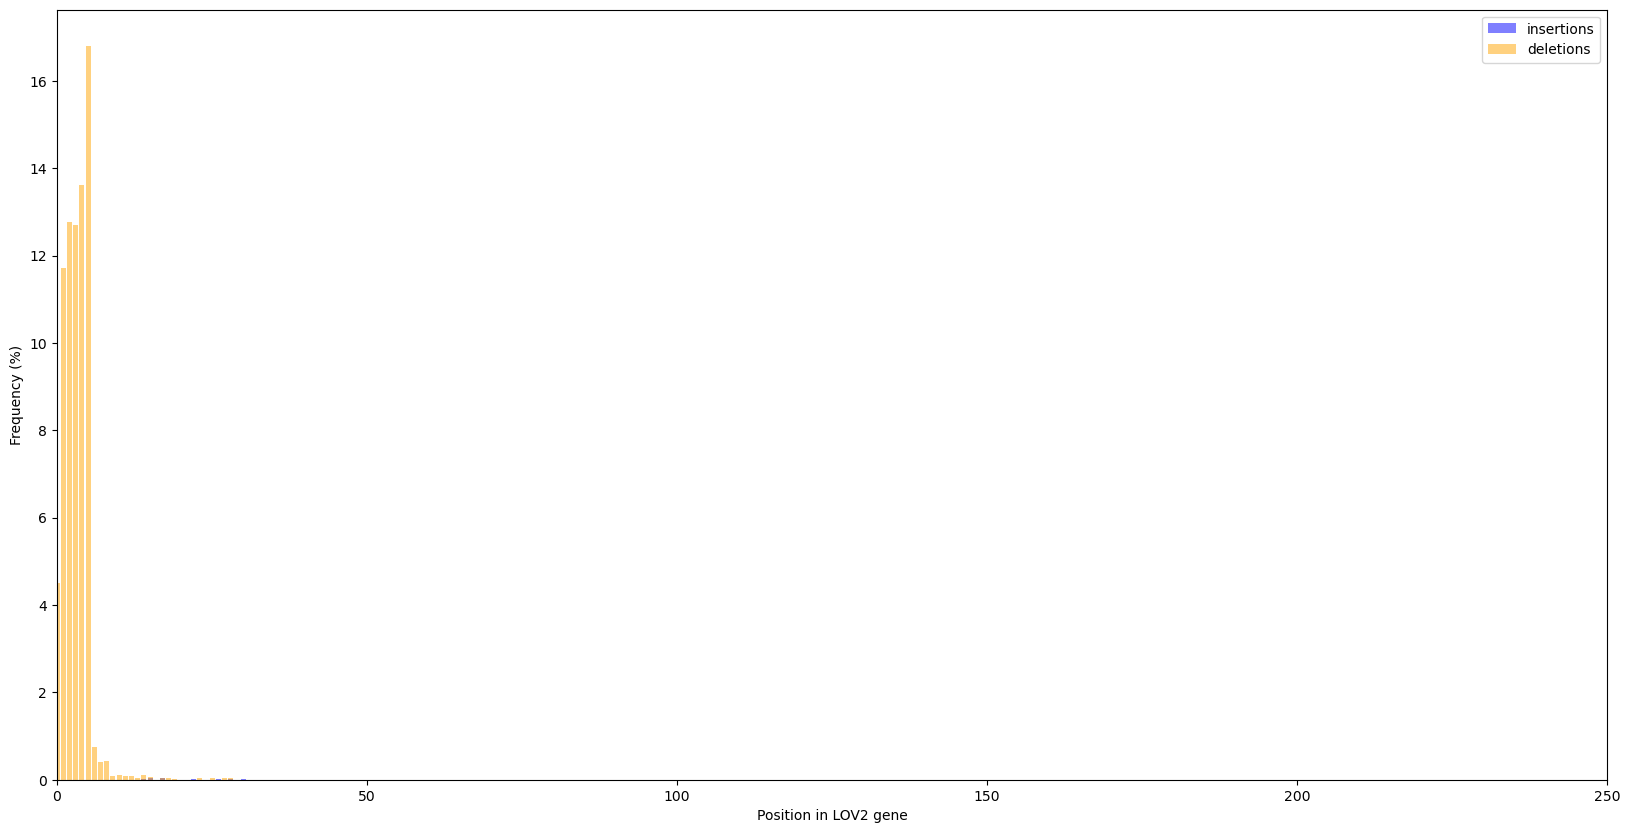

In [21]:
plt.figure(figsize=(20,10))
plt.bar(indels_freq.columns, indels_freq.loc["insertion"]*100, color = "blue", alpha = 0.5, label = "insertions")
plt.bar(indels_freq.columns, indels_freq.loc["deletion"]*100, color = "orange", alpha = 0.5, label = "deletions")
plt.legend()
if read_dir == "R1":
    plt.xlim(0,250)
else: 
    plt.xlim(200,len(LOV2_gene))
plt.ylabel("Frequency (%)")
plt.xlabel("Position in LOV2 gene")
plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_indel_distribution.pdf", bbox_inches="tight")
plt.show()

In [9]:

def get_linker_variants_from_blast_alignment(linker_alignments, wt_linker = "SG", read_dir = "R1"):
    """
    Function to characterize linker variants from the blast alignments

    args: 
    linker_alignments: dict, with the blast algined sequences (hseq, qseq) of the linker
    wt_linker: str, the wildtype linker AA sequence 
    read_dir: str, "R1" or "R2"

    returns:
    linkers: dict, with the counts of the linker variants

    """

    frameshifts = 0
    linkers = {}

    for x in linker_alignments.values():
        qseq = x["qseq"]
        hseq = x["hseq"]

        is_frameshift_read = (qseq.count("-") - hseq.count("-")) %3 != 0
        ##### Exclude frameshift reads 
        if is_frameshift_read: #qseq.count("-") != 0 or hseq.count("-") % 3 != 0:  
            # Insertions (shown as "-" in ref) and deletions that sum up to not multiple of three lead to frameshifts -> exclude these reads
            frameshifts += 1

        ##### WT sequences
        elif qseq == hseq:  # WT linkers with differences in the rest of the sequence are taken into account below
            linkers["wt"] = linkers.get("wt", 0) + 1

        ##### Reads with deletions 
        elif hseq.count("-") > 0:  # Deletions that are multiple of 3, not leading to frameshifts
            #if hseq.count("-") == 3:  
                # 3 deletions represent substitution of SG linker by a single AA, here we might also get some noise, due to sequencing errors that lead to deletions of 3 Nts but this is acceptable
                print("deletion", hseq)
                del_count = int(hseq.count("-") /3)
                hseq_filt = re.sub("-", "", hseq)
                if read_dir == "R2": 
                    linker = translate_dna2aa(hseq_filt)[:len(wt_linker)-(del_count)]  # Linker shortened by 3 Nts = 1 AA
                else: 
                    linker = translate_dna2aa(hseq_filt)[-len(wt_linker)+(del_count):]  # Linker shortened by 3 Nts = 1 AA

                linkers[linker] = linkers.get(linker, 0) + 1

            # else:  # Deletions in the linker region
            #     del_count = hseq.count("-") 
            #     delname = "del-" + str(del_count)
            #     linkers[delname] = linkers.get(delname, 0) + 1

        ###### Reads with substitutions 
        elif qseq.count("-") == 0:  # Linker was substituted, but no deletions or insertions present
            if read_dir == "R2":
                if hseq[:len(wt_linker) * 3] == qseq[:len(wt_linker) * 3]:
                    linkers["wt"] = linkers.get("wt", 0) + 1
                else: 
                    linker = translate_dna2aa(hseq)[:len(wt_linker)]
                    linkers[linker] = linkers.get(linker, 0) + 1
            else: 
                if hseq[-len(wt_linker) * 3:] == qseq[-len(wt_linker) * 3:]:  
                    # WT linker (but differences in the rest (e.g beginning) of the sequence, thus these did not meet the first criterion)
                    linkers["wt"] = linkers.get("wt", 0) + 1
                else: 
                    linker = translate_dna2aa(hseq)[-len(wt_linker):]
                    linkers[linker] = linkers.get(linker, 0) + 1

            
        ###### Reads with insertions
        elif qseq.count("-") > 0:
            insertion_len = qseq.count("-") // 3  # AA level
            if read_dir == "R2": 
                linker = translate_dna2aa(hseq)[:len(wt_linker) + insertion_len]
                linkers[linker] = linkers.get(linker, 0) + 1
            else: 
                linker = translate_dna2aa(hseq)[-len(wt_linker) - insertion_len:]
                linkers[linker] = linkers.get(linker, 0) + 1
        #### All other reads
        else:
            print("sequence", hseq, "does not meet any criteria")
        
    print(frameshifts, "reads excluded due to frameshifts")

    return linkers

In [10]:
linkers = get_linker_variants_from_blast_alignment(linker_alignments=linker_alignments,wt_linker = "GS" if read_dir=="R1" else "IDEAAKGSLH",read_dir=read_dir)

deletion ATTGATGAGGCGGCCAAAG---GCCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAG--AT-CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAATGG---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAG--AT-CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAA--A-CCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAAA-A--CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAACGT---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAC--AT-CTGCATCCGCCGATG
deletion ATTGATGAGGCG------GGGAGCCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAATGG---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAATTT---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAGA-A--CTGCATCCGCCGATGG
deletion ATTGATGAGGCGGCCAAACCG---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAATGG---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAT--AT-CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAA--A-CCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAG---GCCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAA---ACCCTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAAGTG---CTGCATCCGCCGATG
deletion ATTGATGAGGCGGCCAAA---ACCCTGCATCCGCCGATG
deletion ATTGATGAG-

In [11]:
## sort linkers by frequency

linkers_sorted = {k: v for k, v in sorted(linkers.items(), key=lambda item: item[1], reverse=True)}
total_reads = sum(linkers_sorted.values())
linkers_sorted_perc = {k: v/total_reads*100 for k, v in linkers_sorted.items()}

# exclude wt: 
linkers_sorted_perc.pop("wt")
linkers_perc_filt = {k: v for k, v in linkers_sorted_perc.items() if v > 0.05}

In [12]:
sum(linkers_perc_filt.values())

40.59970810667373

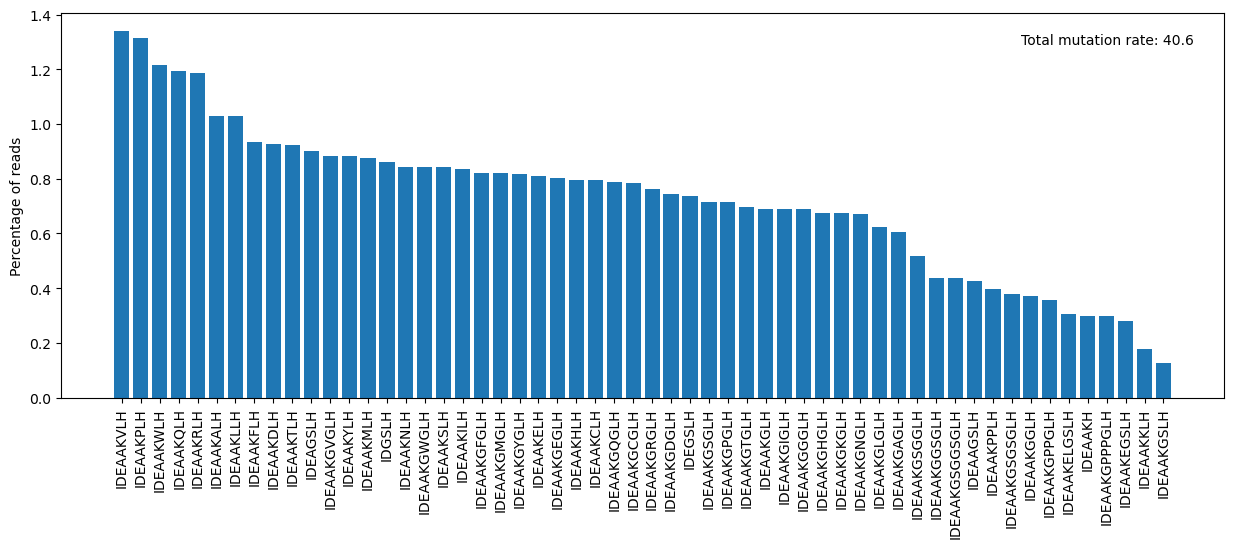

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(linkers_perc_filt.keys(), linkers_perc_filt.values())
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(linkers_perc_filt.values()),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

In [14]:
##
linkernames = list(linkers_perc_filt.keys()).copy()

In [40]:
left_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC1 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T

left_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC2_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC2 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC2_S1_R2_AA_linker_distribution.csv", index_col=0).T

left_linker_BC3 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R1/enrichments/AA/R36_BC3_S1_R1_AA_linker_distribution.csv", index_col=0).T
right_linker_BC3 = pd.read_csv("/home/student/anna/DMS_analysis/final_output/R36/R2/enrichments/AA/R36_BC3_S1_R2_AA_linker_distribution.csv", index_col=0).T


In [41]:
right_linker_BC1 = right_linker_BC1.to_dict(orient="records")[0]
right_linker_BC2 = right_linker_BC2.to_dict(orient="records")[0]
right_linker_BC3 = right_linker_BC3.to_dict(orient="records")[0]

In [42]:
##
linkernames = list(right_linker_BC1.keys()).copy()

In [35]:
def rename_linkers (linkernames, linkerperc_dict): 
    linkers_perc_filt_corr_names = {}
    for startname in linkernames: 
        name = startname
        end_n_del = 0
        start_n_del = 0

        if name.endswith("H"):
            name = name[:-1] 
        else:
            end_n_del += 1

        if name.endswith("L"):
            name = name[:-1]
        else: 
            end_n_del += 1

        # if end_n_del > 0:
        #     if not name.endswith("S"):
        #         print(name)
        #         end_n_del += 1
        #     if not name.endswith("G"):
        #         end_n_del += 1

        if name.startswith("I"): 
            name = name[1:]
        else: 
            start_n_del += 1
        
        if name.startswith("D"):
            name = name[1:]
        else:
            start_n_del += 1
        
        if name.startswith("E"):
            name = name[1:]
        else:
            start_n_del += 1
        
        if name.startswith("A"):
            name = name[1:]
        else:
            start_n_del += 1
        
        if name.startswith("A"):
            name = name[1:]
        else:
            start_n_del += 1
        
        if name.startswith("K"):
            name = name[1:]
        else:
            start_n_del += 1
        
        
        if end_n_del > 0:
            name = f"{name}(+{end_n_del}del)"
        if start_n_del > 0:
            name = f"(-{start_n_del}del){name}"
        
        print(startname , "->", name)
        linkers_perc_filt_corr_names[name] = linkerperc_dict[startname]
    return linkers_perc_filt_corr_names
    

In [45]:
BC1_right_linker = pd.DataFrame(rename_linkers(linkernames = list(right_linker_BC1.keys()), linkerperc_dict=right_linker_BC1), index = ["BC1"])
BC2_right_linker = pd.DataFrame(rename_linkers(linkernames = list(right_linker_BC2.keys()),linkerperc_dict= right_linker_BC2), index = ["BC2"])
BC3_right_linker = pd.DataFrame(rename_linkers(linkernames = list(right_linker_BC3.keys()), linkerperc_dict=right_linker_BC3), index = ["BC3"])

IDEAAKVLH -> V
IDEAAKPLH -> P
IDEAAKWLH -> W
IDEAAKQLH -> Q
IDEAAKRLH -> R
IDEAAKLLH -> L
IDEAAKALH -> A
IDEAAKFLH -> F
IDEAAKDLH -> D
IDEAAKTLH -> T
IDEAGSLH -> (-2del)GS
IDEAAKYLH -> Y
IDEAAKGVGLH -> GVG
IDEAAKMLH -> M
IDGSLH -> (-4del)GS
IDEAAKNLH -> N
IDEAAKGWGLH -> GWG
IDEAAKSLH -> S
IDEAAKILH -> I
IDEAAKGFGLH -> GFG
IDEAAKGMGLH -> GMG
IDEAAKGYGLH -> GYG
IDEAAKELH -> E
IDEAAKCLH -> C
IDEAAKGEGLH -> GEG
IDEAAKHLH -> H
IDEAAKGQGLH -> GQG
IDEAAKGCGLH -> GCG
IDEAAKGRGLH -> GRG
IDEAAKGDGLH -> GDG
IDEGSLH -> (-3del)GS
IDEAAKGSGLH -> GSG
IDEAAKGPGLH -> GPG
IDEAAKGIGLH -> GIG
IDEAAKGTGLH -> GTG
IDEAAKGLH -> G
IDEAAKGGGLH -> GGG
IDEAAKGHGLH -> GHG
IDEAAKGKGLH -> GKG
IDEAAKGNGLH -> GNG
IDEAAKGLGLH -> GLG
IDEAAKGAGLH -> GAG
IDEAAKGSGGLH -> GSGG
IDEAAKGGSGLH -> GGSG
IDEAAKGSGGSGLH -> GSGGSG
IDEAAGSLH -> (-1del)GS
IDEAAKPPLH -> PP
IDEAAKGSGSGLH -> GSGSG
IDEAAKGGLH -> GG
IDEAAKGPPGLH -> GPPG
IDEAAKELGSLH -> ELGS
IDEAAKH -> (+1del)
IDEAAKGPPPGLH -> GPPPG
IDEAAKEGSLH -> EGS
IDEAAKKLH -> K
IDEAAKG

In [51]:
all_right_linkers_vars = list(set(list(BC1_right_linker.columns) + list(BC2_right_linker.columns) + list(BC3_right_linker.columns)))
all_right_linker_perc = pd.DataFrame(columns = all_right_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_right_linkers_vars: 
    if linker in BC1_right_linker.columns:
        all_right_linker_perc.loc["BC1", linker] = BC1_right_linker.loc["BC1", linker]
    if linker in BC2_right_linker.columns:
        all_right_linker_perc.loc["BC2", linker] = BC2_right_linker.loc["BC2", linker] 
    if linker in BC3_right_linker.columns:
        all_right_linker_perc.loc["BC3", linker] = BC3_right_linker.loc["BC3", linker]

In [56]:
all_left_linkers_vars = list(set(list(left_linker_BC1.columns) + list(left_linker_BC2.columns) + list(left_linker_BC3.columns)))
all_left_linker_perc = pd.DataFrame(columns = all_left_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_left_linkers_vars:
    if linker in left_linker_BC1.columns:
        all_left_linker_perc.loc["BC1", linker] = left_linker_BC1.loc["0",linker]
    if linker in left_linker_BC2.columns:
        all_left_linker_perc.loc["BC2", linker] = left_linker_BC2.loc["0",linker]
    if linker in left_linker_BC3.columns:
        all_left_linker_perc.loc["BC3", linker] = left_linker_BC3.loc["0",linker]

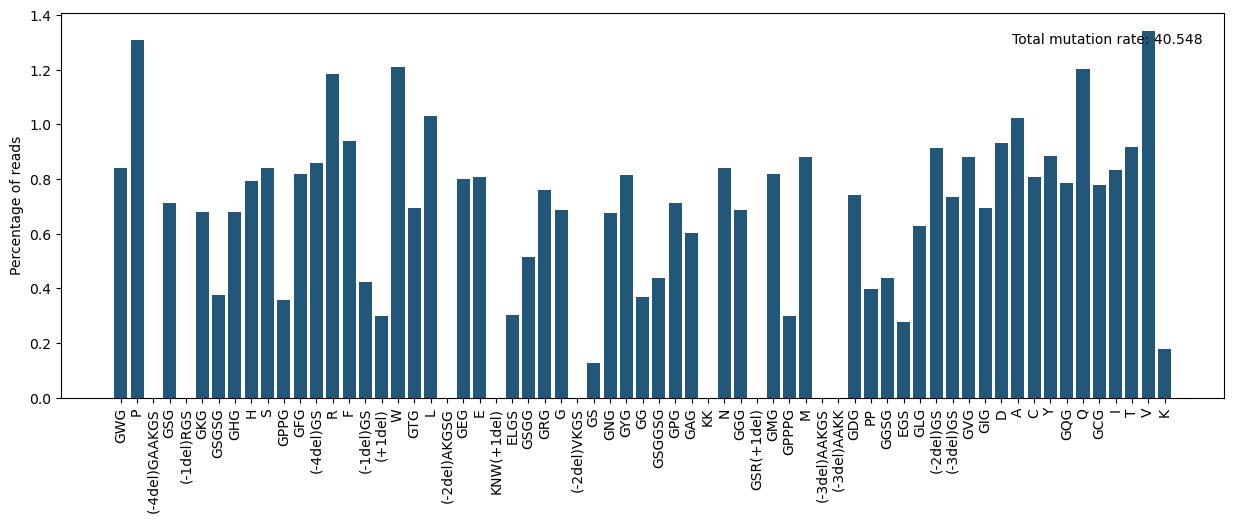

In [61]:
Barcode = "BC1"
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(all_right_linker_perc.columns, all_right_linker_perc.loc[Barcode,:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(all_right_linker_perc.loc[Barcode,:].values),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

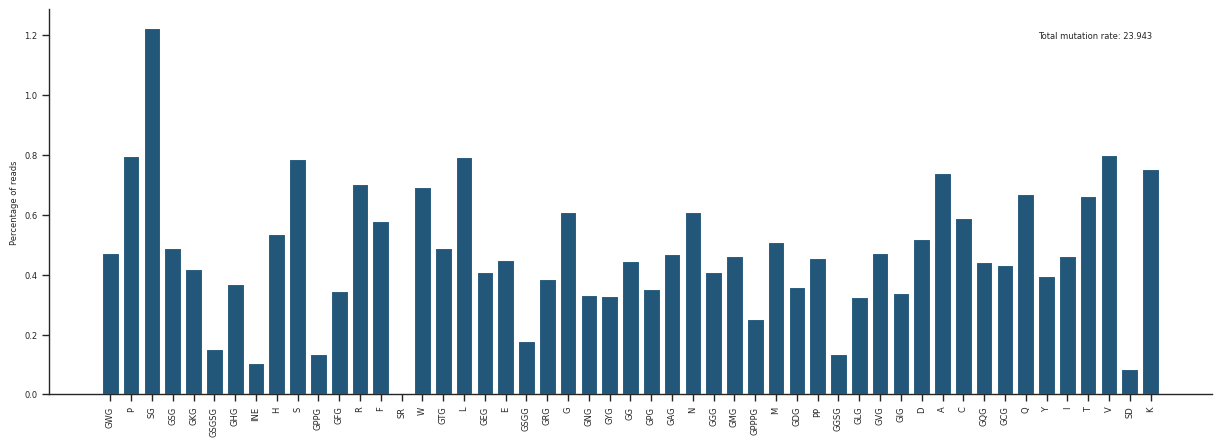

In [85]:
Barcode = "BC1"
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.bar(all_left_linker_perc.columns, all_left_linker_perc.loc[Barcode,:], color = "#22577A")
plt.xticks(rotation=90)
plt.ylabel("Percentage of reads")
plt.text(0.9, 0.93, f"Total mutation rate: {round(sum(all_left_linker_perc.loc[Barcode,:].values),3)}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
#plt.savefig(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.pdf", bbox_inches="tight")
plt.show()

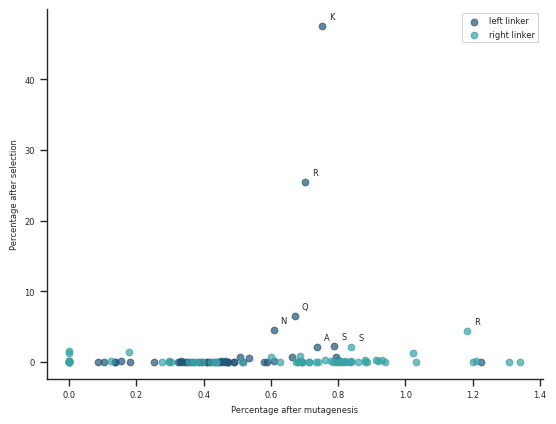

In [84]:
compared_to = "BC3"
plt.scatter(all_left_linker_perc.loc["BC1",:], all_left_linker_perc.loc[compared_to,:], color = "#22577A", alpha=0.7, label = "left linker")
plt.scatter(all_right_linker_perc.loc["BC1",:], all_right_linker_perc.loc[compared_to,:], color = "#38A3A5",alpha=0.7, label = "right linker")
plt.legend(frameon = True)

##
# 80ED99
# 38A3A5
# 57CC99
plt.xlabel("Percentage after mutagenesis")
plt.ylabel("Percentage after selection")
for i, (x, y) in enumerate(zip(all_left_linker_perc.loc["BC1", :], all_left_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_left_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

for i, (x, y) in enumerate(zip(all_right_linker_perc.loc["BC1", :], all_right_linker_perc.loc[compared_to, :])):
    if y > 2:  
        plt.annotate(all_right_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

plt.savefig("/home/student/anna/DMS_analysis/final_output/R36/combined/plots/AA/R36_linker_evolution_scatter.pdf", bbox_inches='tight')
plt.show()


In [ ]:
linker_variants_perc = pd.DataFrame.from_dict(linkers_perc_filt, orient = "index").T
linker_variants_perc.index =[  "observed"]

In [ ]:
linker_variants_perc.to_csv(f"{FigFolder}/{variant}_{Bc}_{read_dir}_linker_distribution.csv")